In [26]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
style.use('ggplot')

### Prepare Dataset

In [14]:

my_word = ENGLISH_STOP_WORDS 

POS_TRAIN_PATH = './dataset/aclImdb/train/pos/'
NEG_TRAIN_PATH = './dataset/aclImdb/train/neg/'
pos_files = os.listdir(POS_TRAIN_PATH)
neg_files = os.listdir(NEG_TRAIN_PATH)
print('Docs prep....')

pos_lines = []
neg_lines = []
for file in pos_files:
    with open(POS_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        pos_lines.extend(lines)
for file in neg_files:
    with open(NEG_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        neg_lines.extend(lines)

docs = []
docs.extend(pos_lines)
docs.extend(neg_lines)
print('Vectorize...')
vectorizer2 = TfidfVectorizer(stop_words=my_word, max_features=250)
vectorizer2.fit(docs)
print('Vectorization done')

input_data2 = vectorizer2.transform(docs).todense()
print(input_data2.shape)
df2 = pd.DataFrame(input_data2)

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

labels2 = []
labels2 = np.append(pos_labels, neg_labels)
df2['labels'] = labels2
# df2.to_csv('data/aclImdb/processed_input_labelled3.csv')

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

X = df2.drop('labels', axis=1)
X = np.array(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df2['labels'], random_state=20)




Docs prep....
Vectorize...
Vectorization done
(25000, 250)
(25000, 250)


### Create NN

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.ln0 = nn.Linear(input_size, 15)
        self.ln1 = nn.Linear(15, output_size)
        

    def forward(self, x):
        output = F.relu(self.ln0(x))
        output = F.tanh(self.ln1(output))
        return output
print(SimpleNN(X_train.shape[1],2))


SimpleNN (
  (ln0): Linear (250 -> 15)
  (ln1): Linear (15 -> 2)
)


### Train and Evaluate

SimpleNN (
  (ln0): Linear (250 -> 15)
  (ln1): Linear (15 -> 2)
)
Epoch 0 loss 0.7028216123580933
Test acc: 0.61744
Epoch 10 loss 0.5165131092071533
Test acc: 0.77888
Epoch 20 loss 0.47582629323005676
Test acc: 0.79056
Epoch 30 loss 0.45762282609939575
Test acc: 0.79968
Epoch 40 loss 0.4495678246021271
Test acc: 0.8016


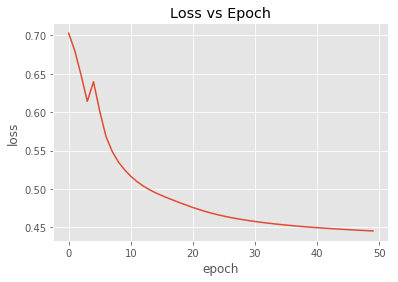

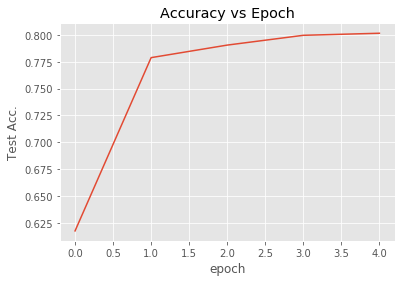

Test accuracy 0.803


In [24]:
net = SimpleNN(X_train.shape[1], 2)
print(net)

def evaluate(X_test,y_test):
    total = len(X_test)
    correct = 0.0
    net.eval()

    for val_x, val_y in zip(X_test, y_test):

        t_x = np.array(val_x).astype(np.float32)
        output = net(Variable(torch.from_numpy(np.array([t_x]))))[0]

        out = output.data.numpy()
        if val_y == 0:

            if not np.argmax(out):
                correct += 1


        if val_y == 1:

            if np.argmax(out):
                correct += 1

#     print('Test accuracy %.3f' % (correct / total))
    return correct / total

epochs = 50
learning_rate = 5e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate)
losses = []
acc = []
epoch_ = []
for epoch in range(epochs):
    net.train()
    inputs = Variable(torch.from_numpy(np.array(X_train).astype(np.float32)))
    targets = Variable(torch.from_numpy(np.array(y_train).astype(np.float32)).long())
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
        
    if epoch % 10 == 0:
        print('Epoch %d loss %s' % (epoch, loss.data[0]))
        test_acc = evaluate(X_test, y_test)
        acc.append(test_acc)
        print('Test acc:', test_acc)

    losses.append(loss.data[0])

plt.title('Loss vs Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)
plt.show()

plt.title('Accuracy vs Epoch')
plt.xlabel('epoch')
plt.ylabel('Test Acc.')
plt.plot(acc)
plt.show()

print('Test accuracy %.3f' % evaluate(X_test, y_test))



### SAVE MODEL

In [25]:
MODELS_DIR = './models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    torch.save(net.state_dict(), MODELS_DIR + '/sentiment.pth')

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd


In [21]:
class Crawler(object):
    
    def __init__(self, url:str,path_to_save:str):
        self.url = url
        self.bsObj = None
        self.links = None
        self.path  = path_to_save + '.txt'
    
    def crawl(self)->list:
        self.bsObj = BeautifulSoup(urlopen(self.url), 'html.parser')
        links = []
        for value in self.bsObj.find_all('div', {'class':'media-body'}):

            links.append((value.find('span',{"class":"time-dt"}).text,value.find('a').attrs['href'],value.find('a').text))
        self.links = links
        return self.links
    
    def save(self)->None:
        if self.path:
            if self.links:
                df = pd.DataFrame(self.links)
                df.to_csv(self.path)
            else:
                print('Crawl before save')
        else:
            print('Select path to save')
    
    def get_article(self, link:str, path:str):
        self.bsObj = BeautifulSoup(urlopen(link))
        


In [22]:

CITIES = ['delhi-news','kolkata', 'mumbai', 'pune-news', 'lucknow', 'mumbai-news']
url = 'http://www.hindustantimes.com/'
if not os.path.exists('./links'):
    os.makedirs('./links')
for city  in CITIES[:1]:
    query_url = url+city
    crawler = Crawler(query_url,'./links/'+city)
    links = crawler.crawl()
#     print(links)
    for link in links:
        print('*'*10)
        print(link)
        bsobj = BeautifulSoup(urlopen(link[1]),'html.parser')
#         para = bsobj.find('div',{"class": "story-details"}).find_all('p')
        para = bsobj.find_all('p')
        for text in para:
            print(text.text)
        
#     crawler.save()
    


**********
('Nov 06, 2017 09:51', 'http://www.hindustantimes.com/delhi-news/offering-liquor-to-underage-friends-at-bar-get-ready-for-a-counselling-session/story-CSAklIOqBciSOQf6LahmRN.html', 'Offering liquor to underage friends at bar? Get ready for a counselling session')

The next time you offer an underage friend or relative a drink at a restro-bar, be prepared to face a pep talk from excise department officials.
The Delhi government’s excise department has decided to counsel and take written undertakings from customers in pubs and restro-bars who are caught sharing or ordering liquor for friends/relatives under 25 years in age.
Sources in the department said teams would conduct surprise checks at restro-bars across the city. “People often come in to lounge bars, order drinks and pass it on to their underage friends or relatives. We have decided to go have a chat with anyone doing so and ask them to give a written undertaking that they won’t offer liquor to an underage person again,

Bharti Airtel, the title sponsor for the Delhi Half Marathon, on Monday asked organisers of the annual foot-race to address concerns of air pollution for it to continue the 10-year-old association, given the serious health risks to participants.
The half marathon, which first featured in 2005, is scheduled for November 19.
In a press statement, Bharti Airtel said it has been a strong supporter of the event over the last decade but has received “a lot of feedback from our customers and citizens at large expressing concern on holding the marathon in view of the prevailing air pollution in the city.”
“For the upcoming edition we have discussed the air quality issue with the organisers, Procam and they have assured us that they are taking several measures to minimise the impact of air pollution on the runners,” it said.
Airtel said the marathon, which infuses the spirit of fitness and good health, is a voluntary event and runners should take into consideration the environmental factors, in

It was his Audi and he wanted it back, real bad. So what if he had sold it to pay off gambling debts.
The black Audi was more than a car for 26-year-old Delhi bookie Amit Kumar. It was a message – to his ex-wife who had walked out on him because he wasn’t earning enough, police said.
Armed with a duplicate key, Kumar on October 11 went to the house of the man he had sold the A4 sedan to and drove off with the car, police said.
His joy ride ended on Saturday when he was arrested from Dwarka in southwest Delhi with the Audi, a pistol and some cartridges.
“I did it because I wanted to show my (ex) wife I was not a loser,” a police officer quoted Kumar as saying when they confronted him with his list of crimes. 
Kumar, who did his schooling from Haryana’s Jhajjar, told police he worked in a call centre in Janakpuri and used to earn around Rs 15,000 a month when he got married in 2013.
His wife was an MBA.
“He told us there were problems right from the start. His wife filed for divorce. She


More than 50 experts from different fields have been pooled in for the ongoing Delhi Walk Festival. Only three of them are foreigners — and he is one of them. While no walk can have more than 30 participants, the only exception is for him — “His group limit is 40 because he is he,” explained an organiser.
The ‘he’ was William Dalrymple, who conducted a long dusty walk on Sunday morning through Mehrauli’s dense jumble of forgotten graves, gateways and domes in south Delhi. 
With the humble hawai chappals as his walking gear, Dalrymple took the visitors to Baagh-e-Naazir in Mehrauli Archaeological Complex and nudged them to gaze upon a ruined gateway as if it were a profound object of beauty. The derelict building, however, began to look appealing after he pointed out barely noticed details such as a Persian poem inscribed on the top of the gateway. 
“It was built by Emperor Muhammad Shah Rangeela”, gushed the walking guide. “He’s the guy I would have loved to have dinner with... he rev


Every day, a man in his early 50s visits Kathputli Colony to distribute rice and dal among its residents, who are living on pavements and under the Shadipur flyover ever since their houses were razed to the ground in a demolition drive by Delhi Development Authority (DDA) on October 30.
Similarly, every morning, a group of women from another locality arrive with tea and toast for the homeless families, who have refused to shift to a nearby transit camp and are staying put at the location.
Those who have offered help are people from the neighbourhood as well as authorities of Prayer Foundation Church (New Patel Nagar) and Bangla Sahib Gurdwara near Connaught Place.
Sukhvinder Singh (52), popular among the residents as “Sardarji”, hires a cycle rickshaw and goes among the homeless with two containers filled with rice and dal. He is also the president of the New Patel Nagar resident welfare association.
Singh was appalled at the dismal conditions of hundreds of residents of the colony li


The family of a man, who drove his car onto the cricket pitch while a Ranji Trophy match was in progress at the Indian Air Force ground in Palam, said he was a “cricket enthusiast” who was merely tempted to watch a match up close.
AK Sharma, the father of ‘pitch inavder’ Girish Kumar, claimed his son wasn’t even aware that a Ranji game with international stars was taking place when he drove on to the ground on Friday. 
AK Sharma said it was the job of the Indian Air Force personnel to secure the entry gate and his son Girish was allegedly caught unaware while driving all the way to the ground. 
“He was coming after dropping his sister to the airport and happened to see a cricket match. Since the ground was accessible, he drove inside with no wrong intent. Once there, it dawned on him that he had just gatecrashed a premier domestic level tournament match and that several international stars he follows were present at the venue, ” said Sharma, a doctor. 
He added that once Girish sensed


The India International Trade Fair will be back at the Pragati Maidan from November 14 to 27, though visitors will not get to see the state pavilions and certain halls, as these have been razed to make way for the proposed International Exhibition-cum-Convention Centre (IECC). 
The number of participants and the area for the fair have been halved and the organisers plan to keep the footfall under check, however, authorities have maintained that visitors will get the “full IITF experience” this year as well. 
The fair was held in an area of 1 lakh sq metres last year. AK Vashist, GM (security) of India Trade Promotion Organisation (ITPO), that organises the trade fair, said this year only a little over half the area will be in commission. Halls 7-12, 12A, and 18 are still standing and will be used during the fair, while six temporary hangars, some as large as 5,000 square metres are being constructed. 
All the state pavilions, and certain buildings including the ‘Hall of Nations’, have

Starting Friday, the number of stations monitoring air quality in the city increased to 35 from the existing 17, with two more stations scheduled to be added to the network by next week.
Officials said air pollution data till now was being recorded by four stations run by the Delhi Pollution Control Committee, eight by the Indian Meteorological Department and five by the Central Pollution Control Board (CPCB).
“Ten new DPCC stations at ITI Shahdara, Mother Dairy Plant in Parparganj, PGDAV College at Sriniwaspuri, Dr Karni Singh Shooting Range, Major Dhyan Chand National Stadium, Jawaharlal Nehru Stadium, DITE Okhla, Satyawati College, DITE Wazirpur and ITI Jahangirpuri were made online on Diwali. Eight more are operational and data from there is available from Friday,” a senior Delhi government official said.
The new stations, which joined the network from Friday, are located at Mahatma Gandhi Institute for Combating Climate Change in Alipur, ITI Narela, Sonia Vihar Water Treatment Pla

Some of the top private schools suspended sports and outdoor activities because of bad air quality in the national capital, which struggles with smog and dust every year after Diwali.
Tagore International School in Vasant Vihar has enforced the restrictions since the festival of lights, celebrated this year on October 19.
The Shri Ram Schools did it on Friday. Sanskriti School in the diplomatic enclave of Chankyapuri will do it from Monday. And the American Embassy School, another premier institution in Chankyapuri, regularly suspends outdoor aerobics when the air quality index (AQI) touches 300.
Springdales School, Sardar Patel Vidyalaya and Ahlcon International School as well as government schools said they will wait until the pollution level gets worse.
According to the government’s “graded response action plan” to cut pollution in the city of more than 20 million people, schools must close when the AQI crosses 500.
The government will take measures in accordance with the anti-pollu

Many Many moons ago, after the fall of the Mughal dynasty in 1857, the poet Ghalib had this to say about his beloved city, Delhi: ‘The existence of Delhi is dependent on many spectacles: The Red Fort, Chandni Chowk, the daily crowds at Jama Masjid, the weekly jaunt around the Jamuna bridge, the annual fair at the Phool Waalo’n ki Sair – now that these five things are gone, Delhi isn’t Delhi.’
Today, the Red Fort is a shell of its former self; Chandni Chowk is a traffic nightmare; the crowds that assembled on the steps of Jama Masjid to watch dastangoi performances, cockfights and enjoy conversations, are now composed of tourists or the faithful who go to offer prayers; and the Jamuna has receded far away.
But the Phool Waalo’n ki Sair still continues, though in a restricted form.
It was a week-long fair in which the emperor, his queens, the royal prince, princesses, nobles and inhabitants of Shahjahanabad went to Mehrauli every year. Much fun would be had by all: there were shopping st

Delhi chief minister Arvind Kejriwal on Thursday met the residents of Kathputli Colony where houses were demolished by the Delhi Development Authority (DDA) on October 30. Kejriwal assured them to provide basic facilities such as food, water and temporary shelter.
Criticising the demolition Kejriwal said that it was “unfortunate” that force was used on the public. “People’s homes have been brutally demolished and young girls are on the roads now, one kid has died and household items have been broken. I am very pained with whatever happened,” he said. 
Kathputli Colony was home to street performers like puppeteers, magicians, singers and musicians. The DDA demolished it to redevelop the area with the help of a private developer. It is the city’s first in-situ redevelopment where people living in the neighbourhood will be housed back into the new flats that will come up in the place of the slum. 
Kejriwal, who was accompanied by transport minister Kailash Gahlot said that the Delhi gover

Four persons conducted a series of robberies and snatchings at gunpoint at various places in north and central Delhi, the police said on Thursday.
Tarun (21), who works as a milk delivery boy in the morning and also has a private job, was returning home in Wazirpur on his motorcycle on October 31 around 6.30am when he was stopped by four men on two motorcycles, they said.
“They came from front and asked me to stop. I thought that they were policemen. They were wearing helmets and leather jackets. One of them put a pistol to my head and another person to the stomach,” Tarun said.
“They threatened to kill me if I did not part with my motorcycle,” he said, adding that he had thought he would be killed that day. The victim said a case of theft was registered instead of robbery, and alleged that the police were not cooperative. Deputy Commissioner of Police (North) Jatin Narwal said that the matter will be inquired into and action will be taken in case any lapses are found.
Following the ro


With winter approaching, shallow fog and mist are expected to engulf Delhi almost every morning over the next one week at least, the regional meteorological department has forecast.
“We are expecting some shallow fog on Saturday and Sunday. For rest of the days, there could be some mist in the morning,” said Kuldeep Srivasatava, scientist with the regional weather forecasting centre in New Delhi. 
The only difference between fog and mist is that during fog the visibility is reduced to less than one kilometre and during mist it is more than one kilometre.Fog and mist are formed when water vapour in the air condenses. During condensation, molecules of water vapour combine to make tiny liquid water droplets that hang in the air.
This means Delhiites would have to start early as there could be traffic snarls due to low visibility. 
Data available with the IMD says that on an average Delhi gets around 50 days of fog every year. While in November, the city gets around seven such days the nu

In [ ]:
delhi_links = pd.DataFrame.from_csv()